In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import CorrelationsTreeCorr # depends on: sqlite3, pandas, treecorr, numpy, and matplotlib

# Need these extra imports to make the PanStarrs Randoms ourselves. 
import treecorr
import numpy
import pandas as pd # to save the files of data
import matplotlib.pyplot as plt

### 1) Define the data paths to use: 
- Need to make the folder in TESTING_PRODUCTS_PATH, not automatically generated in this code. (TODO)

In [3]:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'

TESTING_PRODUCTS_PATH = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

TESTING_PRODUCTS_PATH = TESTING_PRODUCTS_PATH + "16_11_20_R05/"

NOTES_PATH = TESTING_PRODUCTS_PATH + 'RunNotes.txt'

def NotesToWrite(notes):
    NOTES = open(NOTES_PATH, "a")
    NOTES.write(notes)
    NOTES.write("\n \n")
    NOTES.close()

In [4]:
NotesToWrite("Small run with 3 bins")

### 2) Make all of the data Catalogs that you want to use in this notebook with the _Correlation_Data_ class in the _CorrelationsTreeCorr module_

In [5]:
# Initialize object for this notebook:
PanStarrsBossCorrObject = CorrelationsTreeCorr.Correlation_Data(DATA_PATH, TESTING_PRODUCTS_PATH)

In [6]:
PanStarrs_Data_all_query = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"
PanSTARRS_data_all_df = PanStarrsBossCorrObject.makeDataCatalogs("PanSTARRS.db", PanStarrs_Data_all_query)
NotesToWrite('PanStarrs_Data_all_query: ' + PanStarrs_Data_all_query)

dataFrame: 
          ID       DEC        RA    zSN  zHost
0  ps0909006  1.184831  333.9500  0.284 -999.0
1  ps0909010 -4.078911   37.1182  0.270 -999.0
2  ps0910017 -5.023289   35.2775  0.320 -999.0


In [7]:
# Only 9 pointings from PanStarrs Overlap with the BOSS field so when doing the cross correlation need to only take these 9:
PanSTARRS_Data_only_9_query = """SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (DEC > -20) AND ((zSN > -999) OR (zHost > -999))"""
PanSTARRS_Data_only_9_df = PanStarrsBossCorrObject.makeDataCatalogs("PanSTARRS.db", PanSTARRS_Data_only_9_query)
NotesToWrite('PanSTARRS_Data_only_9_df: ' + PanSTARRS_Data_only_9_query)


dataFrame: 
          ID       DEC        RA    zSN  zHost
0  ps0909006  1.184831  333.9500  0.284 -999.0
1  ps0909010 -4.078911   37.1182  0.270 -999.0
2  ps0910017 -5.023289   35.2775  0.320 -999.0


In [8]:
BOSS_Data_All_query = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"
BOSS_Data_All_df = PanStarrsBossCorrObject.makeDataCatalogs("CMASS_and_LOWZ.db", BOSS_Data_All_query)
NotesToWrite('BOSS_Data_All_query: ' + BOSS_Data_All_query)

dataFrame: 
   index          RA       DEC         Z        NZ
0      0  195.071285 -0.590771  0.465648  0.000345
1      0  321.480329  9.973440  0.301401  0.000390
2      1  195.022992 -0.610999  0.565802  0.000319


In [9]:
BOSS_Rands_Limit_query = """SELECT * FROM CMASSLOWZTOT_South_rands 
    WHERE `index` IN (SELECT `index`FROM CMASSLOWZTOT_South_rands ORDER BY RANDOM() LIMIT 10000000) UNION 
    SELECT * FROM CMASSLOWZTOT_North_rands 
    WHERE `index`  IN (SELECT `index` FROM CMASSLOWZTOT_North_rands ORDER BY RANDOM() LIMIT 10000000)"""
BOSS_Rands_Limit_df = PanStarrsBossCorrObject.makeDataCatalogs("CMASS_and_LOWZ_rands.db", BOSS_Rands_Limit_query)
NotesToWrite('BOSS_Rands_Limit_query: ' + BOSS_Rands_Limit_query)

dataFrame: 
   index          RA        DEC         Z        NZ
0      3  136.005100  58.619961  0.520083  0.000411
1      6   13.554506   0.848970  0.343853  0.000376
2      7    2.542393  33.080067  0.176604  0.000588


In [10]:
zBest = []
for i in PanSTARRS_Data_only_9_df.iterrows(): #.iterrows() returns a tuple (immutable object)
    if i[1]['zSN'] >= 0:
        zBest.append(i[1]['zSN'])
    else:
        zBest.append(i[1]['zHost'])
        
if PanSTARRS_Data_only_9_df.shape[0] == len(zBest):
    PanSTARRS_Data_only_9_df['zBest'] = zBest

PanSTARRS_Data_only_9_df.head(3)

,ID,DEC,RA,zSN,zHost,zBest
0,ps0909006,1.184831,333.9500,0.284,-999.0,0.284
1,ps0909010,-4.078911,37.1182,0.270,-999.0,0.270
2,ps0910017,-5.023289,35.2775,0.320,-999.0,0.320


## 3) Need to make PanStarrs randoms ourselves as there is no dataset for that (that we have access to):

In [12]:
cat_PanSTARRS_Full = treecorr.Catalog(ra=PanSTARRS_data_all_df['RA'], dec=PanSTARRS_data_all_df['DEC'], ra_units='degrees', dec_units='degrees')
randsLength = 10**8

ra_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.ra)
ra_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.ra)
dec_min_PanSTARRS = numpy.min(cat_PanSTARRS_Full.dec)
dec_max_PanSTARRS = numpy.max(cat_PanSTARRS_Full.dec)
#print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
#print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, randsLength)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), randsLength)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433], "MD02": [053.100, -27.800],}

radius = (3.3/2) * numpy.pi / 180.0

maskRA = []
maskDEC = []
randoms_Lengths = []

for pointing in pointings: 
    
    #print(pointings[pointing])
    center_dec = pointings[pointing][1] * numpy.pi / 180
    center_ra = pointings[pointing][0] * numpy.pi / 180

    angular_seps = numpy.arccos(numpy.cos(numpy.pi / 2 - center_dec) * numpy.cos(numpy.pi / 2 - rand_dec_PanSTARRS) + 
                                numpy.sin(numpy.pi / 2 - center_dec) * numpy.sin(numpy.pi / 2 - rand_dec_PanSTARRS) * 
                                numpy.cos(center_ra - rand_ra_PanSTARRS))

    ras_in_circle = rand_ra_PanSTARRS[angular_seps < radius]
    #print(len(ras_in_circle))
    ras_in_circle = ras_in_circle * 180 / numpy.pi
    decs_in_circle = rand_dec_PanSTARRS[angular_seps < radius]
    #print(len(decs_in_circle))
    decs_in_circle = decs_in_circle * 180 / numpy.pi
    
    maskRA.extend(ras_in_circle)
    maskDEC.extend(decs_in_circle)
    
    randoms_Lengths.append(len(ras_in_circle))
print("done. Length of randoms: " + str(len(maskRA)))
NotesToWrite('maskRA: ' + str(randsLength))
NotesToWrite('in all 10 pointings:: ' + str(len(maskRA)))


done. Length of randoms: 340739


In [13]:
# Need to get just 9 pointings from PanSTARRS for Boss Cross Correlation: 
            
radius = (3.3/2) * numpy.pi / 180.0

maskRA_overlap = []
maskDEC_overlap = []
randoms_Lengths_overlap = []

for pointing in pointings: 
    if(pointing == "MD02"):
        continue
    else:    
        center_dec = pointings[pointing][1] * numpy.pi / 180
        center_ra = pointings[pointing][0] * numpy.pi / 180

        angular_seps = numpy.arccos(numpy.cos(numpy.pi / 2 - center_dec) * numpy.cos(numpy.pi / 2 - rand_dec_PanSTARRS) + 
                                    numpy.sin(numpy.pi / 2 - center_dec) * numpy.sin(numpy.pi / 2 - rand_dec_PanSTARRS) * 
                                    numpy.cos(center_ra - rand_ra_PanSTARRS))

        ras_in_circle = rand_ra_PanSTARRS[angular_seps < radius]
        ras_in_circle = ras_in_circle * 180 / numpy.pi
        decs_in_circle = rand_dec_PanSTARRS[angular_seps < radius]
        decs_in_circle = decs_in_circle * 180 / numpy.pi

        maskRA_overlap.extend(ras_in_circle)
        maskDEC_overlap.extend(decs_in_circle)

        randoms_Lengths_overlap.append(len(ras_in_circle))
print("done. Length of randoms: " + str(len(maskRA_overlap)))
NotesToWrite('randsLength: ' + str(randsLength))
NotesToWrite('in all 9 pointings: ' + str(len(maskRA_overlap)))


done. Length of randoms: 308709


## 4) Bin the Data into 5 redhsift bins: [0.0, 0.3, 0.7, 1.0]

In [14]:
#PanSTARRS_Data_only_9_df_1 = PanSTARRS_Data_only_9_df.iloc[PanSTARRS_Data_only_9_df['zBest'] >= 0.0 and PanSTARRS_Data_only_9_df['zBest'] <= 0.2].item()

PanSTARRS_Data_only_9_df_Z1 = PanSTARRS_Data_only_9_df[PanSTARRS_Data_only_9_df['zBest'].between(0.0, 0.3, inclusive=False)]
PanSTARRS_Data_only_9_df_Z2 = PanSTARRS_Data_only_9_df[PanSTARRS_Data_only_9_df['zBest'].between(0.3, 0.7, inclusive=False)]
PanSTARRS_Data_only_9_df_Z3 = PanSTARRS_Data_only_9_df[PanSTARRS_Data_only_9_df['zBest'].between(0.7, 1.0, inclusive=False)]

In [15]:
BOSS_Data_All_df_Z1 = BOSS_Data_All_df[BOSS_Data_All_df['Z'].between(0.0, 0.3, inclusive=False)]
BOSS_Data_All_df_Z2 = BOSS_Data_All_df[BOSS_Data_All_df['Z'].between(0.3, 0.7, inclusive=False)]
BOSS_Data_All_df_Z3 = BOSS_Data_All_df[BOSS_Data_All_df['Z'].between(0.7, 1.0, inclusive=False)]

## 5A) Define RA/DEC for the data/random sets - All RedShift Bins, use randoms for all

In [16]:
PanStarrs_Rands_Only_9_RADEC = [maskRA_overlap, maskDEC_overlap]
BOSS_Rands_Limit_RADEC = [BOSS_Rands_Limit_df['RA'], BOSS_Rands_Limit_df['DEC']]

In [17]:
PanStarrs_Data_Only_9_RADEC_Z1 = [PanSTARRS_Data_only_9_df_Z1['RA'], PanSTARRS_Data_only_9_df_Z1['DEC']]
PanStarrs_Data_Only_9_RADEC_Z2 = [PanSTARRS_Data_only_9_df_Z2['RA'], PanSTARRS_Data_only_9_df_Z2['DEC']]
PanStarrs_Data_Only_9_RADEC_Z3 = [PanSTARRS_Data_only_9_df_Z3['RA'], PanSTARRS_Data_only_9_df_Z3['DEC']]

BOSS_Data_RADEC_Z1 = [BOSS_Data_All_df_Z1['RA'], BOSS_Data_All_df_Z1['DEC']]
BOSS_Data_RADEC_Z2 = [BOSS_Data_All_df_Z2['RA'], BOSS_Data_All_df_Z2['DEC']]
BOSS_Data_RADEC_Z3 = [BOSS_Data_All_df_Z3['RA'], BOSS_Data_All_df_Z3['DEC']]

## 6) Make a Cross Correlations: 

In [18]:
PanStarrs_Z = [PanStarrs_Data_Only_9_RADEC_Z1, PanStarrs_Data_Only_9_RADEC_Z2, 
               PanStarrs_Data_Only_9_RADEC_Z3]

Boss_Z = [BOSS_Data_RADEC_Z1, BOSS_Data_RADEC_Z2, BOSS_Data_RADEC_Z3]

bins = ["0.0-.3", ".3-.7", ".7-1.0"]

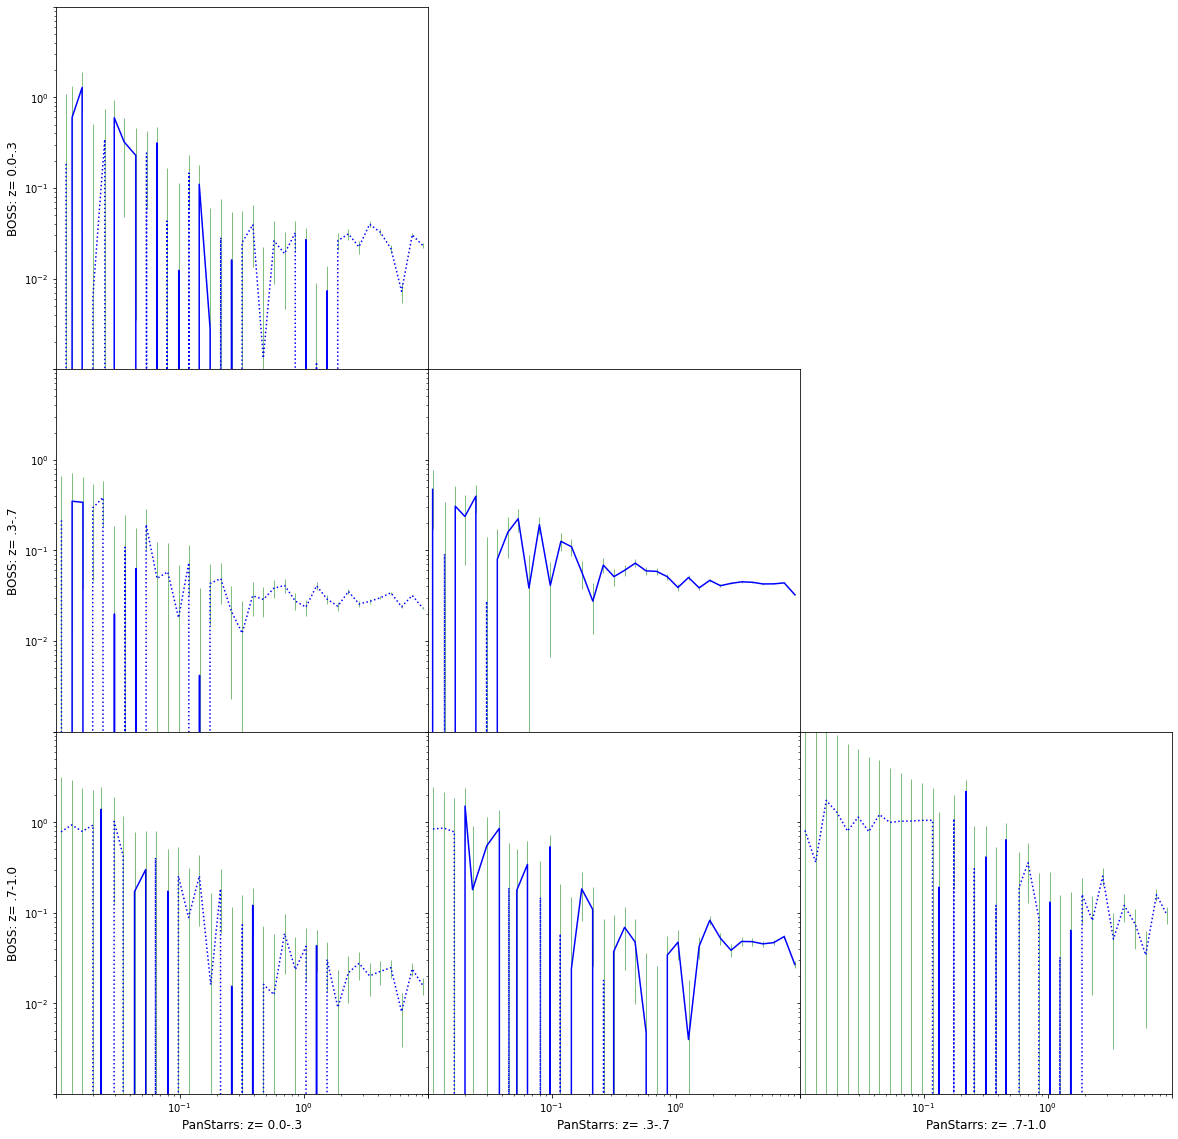

In [19]:
fig, axs = plt.subplots(len(PanStarrs_Z), len(Boss_Z), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(20, 20))

for i in range(len(PanStarrs_Z)):
    for j in range(i, len(PanStarrs_Z)):
        r, xi, varxi, sig = PanStarrsBossCorrObject.crossCorrelation(PanStarrs_Z[i], PanStarrs_Rands_Only_9_RADEC, 
                                                             Boss_Z[j], BOSS_Rands_Limit_RADEC)
        Plot_Results_dict = {'r': r, 'xi': xi, 'varxi':varxi, 'sig':sig}
        Plot_Results_df = pd.DataFrame(data=Plot_Results_dict)
        Plot_Results_df.to_csv(TESTING_PRODUCTS_PATH+'CrossCorr_Pan_X_Boss_'+str(i)+"_"+str(j))
     
        axs[j, i].plot(r, xi, color='blue')
        axs[j, i].plot(r, -xi, color='blue', ls=':')
        axs[j, i].errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='green', lw=0.5, ls='')
        axs[j, i].errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='green', lw=0.5, ls='')
        
        axs[j, i].set_xlabel("PanStarrs: z= " + bins[i], fontsize = 12)
        axs[j, i].set_ylabel("BOSS: z= " + bins[j], fontsize = 12)
        #axs[j, i].set_xlabel(r'$\theta$ (degrees)', fontsize = 12)
        #axs[j, i].set_ylabel(r'$w(\theta)$', fontsize = 12)
        axs[j, i].set_xscale('log')
        axs[j, i].set_yscale('log', nonpositive='clip')
        axs[j, i].set_ylim([.001, 10])
        axs[j, i].set_xlim([0.01,10])
        axs[j, i].set_xticks([0.01, .1, 1, 10])
        axs[j, i].set_xticklabels(["", "$10^{-1}$", "$10^{0}$", ""])
        axs[j, i].set_yticks([0.001, .01, .1, 1, 10])
        axs[j, i].set_yticklabels(["", "$10^{-2}$", "$10^{-1}$","$10^{0}$", ""])
        
        #axs[j, i].set_title("PanS: "+bins[i]+" X "+"BOSS: "+bins[j])
        
        
for i in range(len(PanStarrs_Z)):
    for j in range(0, i):
        axs[j, i].set_visible(False)
        
for ax in axs.flat:
    ax.label_outer()
        
        
plt.savefig(TESTING_PRODUCTS_PATH + "CrossCorrelations_3Bins", facecolor='white')